# a notebook to figure out some plotting stuff
- for example, a strikezone view of the pitches when they cross the plate
- 3d trails if I can figure that out ( I think there are polynomials in the baseball savant endpoint here: https://baseballsavant.mlb.com/gf?game_pk=) 

In [1]:
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup
from pybaseball import statcast_batter, spraychart, plot_stadium

import requests
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

In [2]:
# this defaults to yesterday
#end_dt = '2023-03-30'
# remember this will be utc 
end_dt = str(datetime.date.today() + datetime.timedelta(days=-1))


df = statcast(start_dt=end_dt, end_dt=end_dt)

print(df.shape)

This is a large query, it may take a moment to complete


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.89s/it]

(4026, 92)


In [3]:
df.head(20)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
1390,SL,2023-04-04,86.8,-1.69,5.67,"Jameson, Drey",443558,686753,strikeout,swinging_strike_blocked,...,8,8,6,6,8,Standard,Standard,20,-0.046,-0.119
1417,SL,2023-04-04,85.2,-1.75,5.64,"Jameson, Drey",443558,686753,NaN,swinging_strike,...,8,8,6,6,8,Standard,Standard,26,0.0,-0.14
1448,SL,2023-04-04,84.8,-2.06,5.63,"Jameson, Drey",443558,686753,NaN,swinging_strike,...,8,8,6,6,8,Standard,Standard,35,0.002,-0.045
1485,SI,2023-04-04,92.9,-2.2,5.67,"Jameson, Drey",665742,686753,single,hit_into_play,...,8,8,6,6,8,Strategic,Standard,227,0.03,0.103
1537,SI,2023-04-04,94.3,-2.0,5.66,"Jameson, Drey",665742,686753,NaN,ball,...,8,8,6,6,8,Strategic,Standard,228,0.0,0.027
1566,FF,2023-04-04,95.9,-1.69,5.86,"Jameson, Drey",663757,686753,home_run,hit_into_play,...,8,8,6,6,8,Strategic,Standard,208,0.009,0.938
1598,FF,2023-04-04,95.2,-1.82,5.79,"Jameson, Drey",663757,686753,NaN,foul,...,8,8,5,5,8,Strategic,Standard,218,0.0,0.0
1653,FF,2023-04-04,98.0,-1.66,5.83,"Jameson, Drey",663757,686753,NaN,ball,...,8,8,5,5,8,Strategic,Standard,210,0.0,0.064
1686,SI,2023-04-04,92.7,-2.19,5.62,"Jameson, Drey",663757,686753,NaN,swinging_strike,...,8,8,5,5,8,Standard,Standard,225,0.0,-0.054
1734,CH,2023-04-04,88.7,-2.05,5.6,"Jameson, Drey",663757,686753,NaN,ball,...,8,8,5,5,8,Standard,Standard,236,0.0,0.048


In [4]:
df.pitcher.value_counts()

664285    103
645261    100
622491     99
676664     98
608566     95
         ... 
666374      5
594580      5
669796      4
669276      3
660593      3
Name: pitcher, Length: 116, dtype: Int64

In [5]:
a_pitch = df.loc[1]

In [6]:
a_pitch

pitch_type                                CH
game_date                2023-04-04 00:00:00
release_speed                           91.9
release_pos_x                           0.46
release_pos_z                           6.22
                                ...         
if_fielding_alignment               Standard
of_fielding_alignment               Standard
spin_axis                                134
delta_home_win_exp                       0.0
delta_run_exp                         -0.027
Name: 1, Length: 92, dtype: object

In [7]:
a_pitch.game_pk

718705

In [8]:
pitch_abbreviation_to_name = {
    "FF" : "4-Seam Fastball",
    "CU" : "Curveball",
    "CH" : "Changeup",
    "FC" : "Cutter",
    "EP" : "Eephus",
    "FO" : "Forkball",
    "KN" : "Knuckleball",
    "KC" : "Knuckle-curve",
    "SC" : "Screwball",
    "SI" : "Sinker",
    "SL" : "Slider",
    "FS" : "Splitter",
    "FT" : "2-Seam Fastball",
    "ST" : "Sweeper",
    "SV" : "Slurve"
}

In [9]:
# Do this again, but for all pitches

all_pitches = df[df.pitcher == 664285]
# here is the game that he pitched in https://www.youtube.com/watch?v=r5-DFUnWevY

In [10]:
all_pitches.pitch_type.value_counts()

SI    52
CH    23
CU    23
FC     5
Name: pitch_type, dtype: int64

In [11]:
all_pitches.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

## Quick things to make this better
- turn into a function
- different colors for different pitch types
- draw a plate?
- markers that show speed and type
- maybe movement with like a empty circle, vector, filled circle


maybe make it infer which kind of plot to make?

In [12]:
def plot_strike_zone(pitch_df: pd.DataFrame, title: str = '', colorby: str = 'pitch_type', annotation: str = None, axis = None) -> None:
    """
    Produces a pitches overlaid on a strike zone using statcast data
    
    Args:
        pitch_df: (pandas.DataFrame)
            StatCast pandas.DataFrame of StatCast batter data
        title: (str), default = ''
            Optional: Title of plot
        colorby: (str), default = 'pitch_type'
            Optional: Which category to color the mark with. 'pitch_type','pitcher', 'description' or a column within data
        legend_title: (str), default = based on colorby
            Optional: Title for the legend
        width: (int), default = 500
            Optional: Width of plot (not counting the legend)
        height: (int), default = 500
            Optional: Height of plot
    Returns:
        A matplotlib.axes.Axes object that was used to generate the pitches overlaid on the strike zone
    """
    
    
    # some things to auto adjust formatting
    # make the markers really visible when fewer pitches
    alpha_markers = min(0.8, 0.5 + 1 / pitch_df.shape[0])
    alpha_text = alpha_markers + 0.2
    
    # define Matplotlib figure and axis
    if axis is None:
        fig, axis = plt.subplots()

    # add home plate to plot 
    home_plate_coords = [[-0.71, 0], [-0.85, -0.5], [0, -1], [0.85, -0.5], [0.71, 0]]
    plate = Polygon(home_plate_coords,
                edgecolor = 'darkgray',
                facecolor = 'lightgray',
                lw = 2)
    axis.add_patch(plate)
    
    # add strike zone to plot. technically this can vary by batter
    # ignore that for now
    axis.add_patch(Rectangle((-0.71, 1.5), 2*0.71, 2,
                 edgecolor = 'lightgray',
                 fill=False,
                 lw=3))
    
    legend_title = ""
    color_label = ""
    
    # to avoid the SettingWithCopyWarning error
    sub_data = pitch_df.copy().reset_index(drop=True)
    
    if colorby == 'pitch_type':
        color_label = 'pitch_type'
        
        if not legend_title:
            legend_title = 'Pitch Type'
            
    elif colorby == 'description':
        values = sub_data.loc[:, 'description'].str.replace('_', ' ').str.title()
        sub_data.loc[:, 'desc'] = values
        color_label = 'desc'
        
        if not legend_title:
            legend_title = 'Pitch Description'
    elif colorby == 'pitcher':
        color_label = 'player_name'
        
        if not legend_title:
            legend_title = 'Pitcher'
            
    elif colorby == "events":
        # only things where something happened
        sub_data = sub_data[sub_data['events'].notna()]
        sub_data['event'] = sub_data['events'].str.replace('_', ' ').str.title()
        color_label = 'event'
        
        if not legend_title:
            legend_title = 'Outcome'
    
    else:
        color_label = colorby
        if not legend_title:
            legend_title = colorby
        
    scatters = []
    
    for color in sub_data[color_label].unique():
        color_sub_data = sub_data[sub_data[color_label] == color]
        scatters.append(axis.scatter(
            color_sub_data["plate_x"],
            color_sub_data['plate_z'],
            s = 10**2,
            label = pitch_abbreviation_to_name[color] if color_label == 'pitch_type' else color,
            alpha = alpha_markers
        ))

        
        # add an annotation at the center of the marker
        if annotation:
            for i, pitch_coord in zip(color_sub_data.index, zip(color_sub_data["plate_x"], color_sub_data['plate_z'])):
                label_formatted = color_sub_data.loc[i, annotation]
                label_formatted = label_formatted if not pd.isna(label_formatted) else ""
                
                if annotation in ["release_speed", "effective_speed", "launch_speed"] and label_formatted != "":
                    label_formatted = "{:.0f}".format(label_formatted)
                
                axis.annotate(label_formatted,
                            pitch_coord,
                            size = 7,
                            ha = 'center',
                            va = 'center',
                            alpha = alpha_text)

    axis.set_xlim(-4, 4)
    axis.set_ylim(-1.5, 7)
    
    axis.axis('off')

    axis.legend(handles=scatters, title=legend_title, bbox_to_anchor=(0.85, 1), loc='upper left')
    plt.title(title)

    #plt.show()
    
    #return ax
    
    

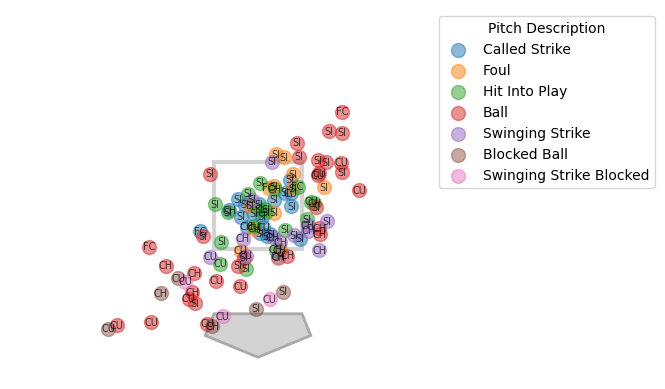

In [13]:
all_pitches = df[df["pitcher"] == 664285]

plot_strike_zone(all_pitches, colorby = 'description', annotation = "pitch_type")

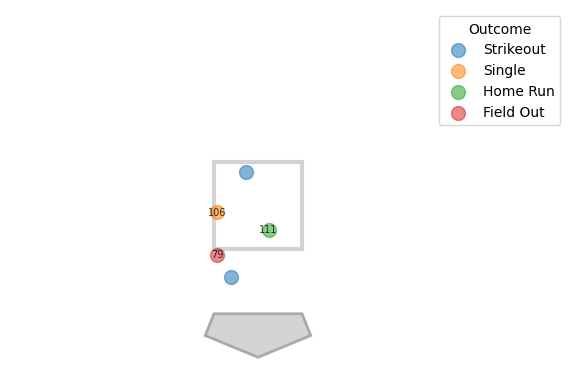

In [14]:
plot_strike_zone(df.iloc[:20], colorby = 'events', annotation = "launch_speed")

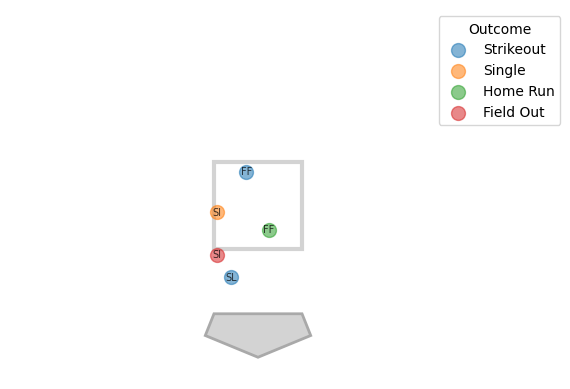

In [15]:
plot_strike_zone(df.iloc[:20], colorby = 'events', annotation = "pitch_type")

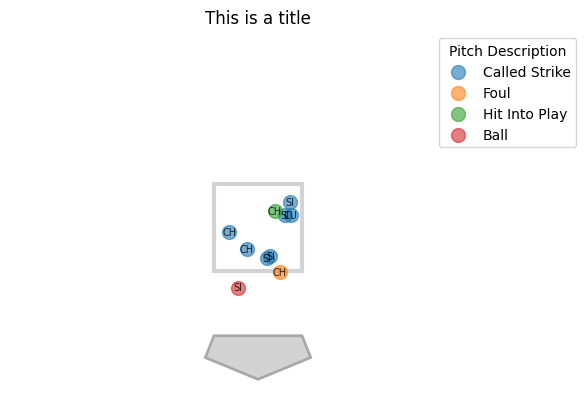

In [16]:
plot_strike_zone(all_pitches.iloc[:10], title = "This is a title", colorby = 'description', annotation = "pitch_type")

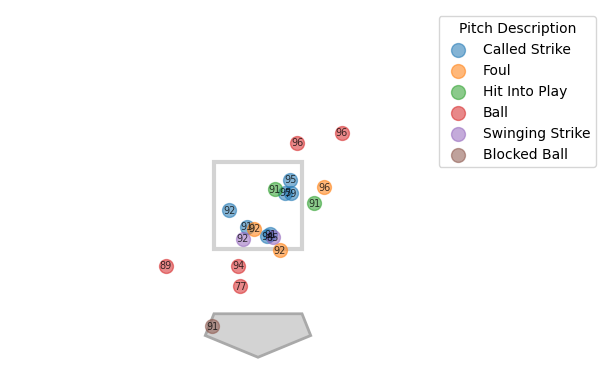

In [17]:
plot_strike_zone(all_pitches.iloc[:20], colorby = 'description', annotation = "release_speed")

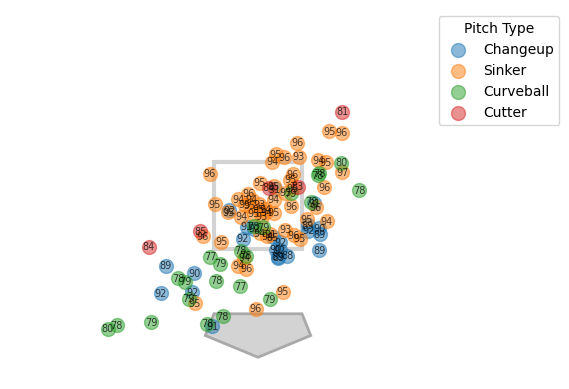

In [18]:
plot_strike_zone(all_pitches, colorby = 'pitch_type', annotation = "release_speed")

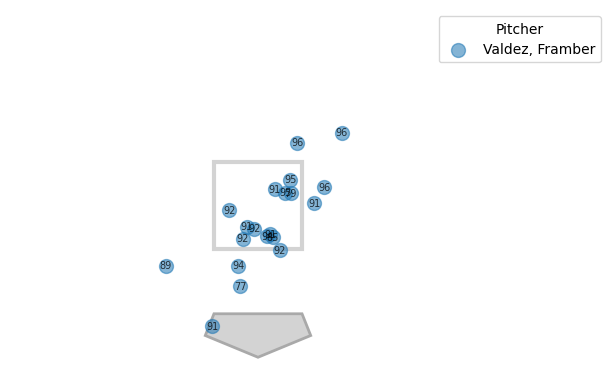

In [19]:
plot_strike_zone(all_pitches.iloc[:20], colorby = 'pitcher', annotation = "release_speed")

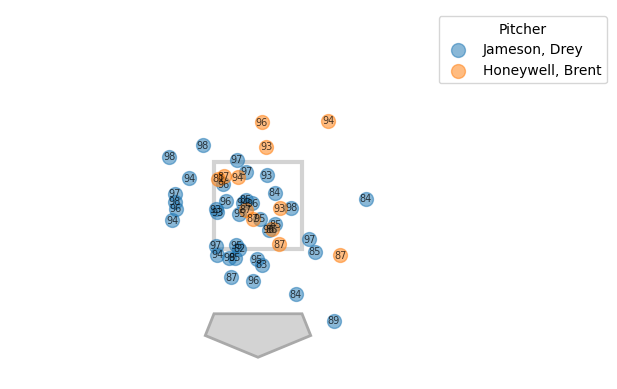

In [20]:
plot_strike_zone(df.iloc[:50], colorby = 'pitcher', annotation = "release_speed")

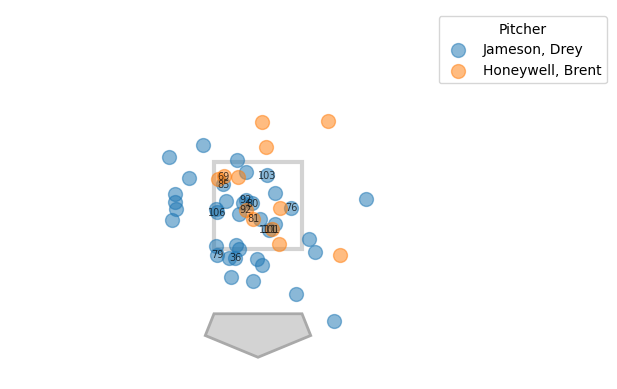

In [21]:
plot_strike_zone(df.iloc[:50], colorby = 'pitcher', annotation = "launch_speed")

## figure out how to put this side by side

In [22]:
# I think I need to add an optional axis argument in the spraychart fucntion so I can pass in as a subgraph

# how to preserve the aspect ratio?
# I think this is what I need
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/mosaic.html

In [23]:
def spraychart1(data: pd.DataFrame, team_stadium: str, title: str = '', tooltips = None,  # pylint: disable=too-many-arguments
               size: int = 100, colorby: str = 'events', legend_title: str = '', width: int = 500,
               height: int = 500, axis = None):
    """
    Produces a spraychart using statcast data overlayed on specified stadium
    
    Args:
        data: (pandas.DataFrame)
            StatCast pandas.DataFrame of StatCast batter data
        team_stadium: (str)
            Team whose stadium the hits will be overlaid on
        title: (str), default = ''
            Optional: Title of plot
        tooltips: (List[str]), default = None
            Optional: List of variables in data to include as tooltips (Deprecated)
        size: (int), default = 100
            Optional: Size of hit circles on plot
        colorby: (str), default = 'events'
            Optional: Which category to color the mark with. 'events','player', or a column within data
        legend_title: (str), default = based on colorby
            Optional: Title for the legend
        width: (int), default = 500
            Optional: Width of plot (not counting the legend)
        height: (int), default = 500
            Optional: Height of plot
    Returns:
        A matplotlib.axes.Axes object that was used to generate the stadium render and the spraychart
    """

    # pull stadium plot to overlay hits on
    base = plot_stadium(team_stadium, title, width-50, height, axis=axis)

    # only plot pitches where something happened
    sub_data = data.copy().reset_index(drop=True)
    sub_data = sub_data[sub_data['events'].notna()][sub_data['hc_x'].notna()][sub_data['hc_y'].notna()]
    if colorby == 'events':
        sub_data['event'] = sub_data['events'].str.replace('_', ' ').str.title()
        color_label = 'event'
        if not legend_title:
            legend_title = 'Outcome'
    elif colorby == 'player':
        color_label = 'player_name'
        if not legend_title:
            legend_title = 'Player'
    else:
        color_label = colorby
        if not legend_title:
            legend_title = colorby

    # scatter plot of hits
    scatters = []
    for color in sub_data[color_label].unique():
        color_sub_data = sub_data[sub_data[color_label] == color]
        scatters.append(base.scatter(
            color_sub_data["hc_x"], color_sub_data['hc_y'].mul(-1), size, label=color, alpha=0.5
        ))

    if tooltips:
        warnings.warn(
            "Tooltips are disabled in the pyplot version of spraychart and will be removed in the future",
            category=DeprecationWarning
        )

    plt.legend(handles=scatters, title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')

    #plt.draw()

    #plt.show()

    #return base

C:\Users\matth\anaconda3\envs\three-true-outcomes\lib\site-packages\pybaseball\plotting.py:135: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_data = sub_data[sub_data['events'].notna()][sub_data['hc_x'].notna()][sub_data['hc_y'].notna()]


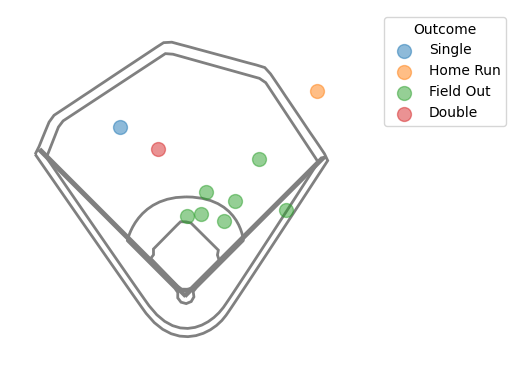

In [24]:
spray_ax = spraychart(df.iloc[:50], "orioles", height = 400, width=400)

In [25]:
spray_ax

<Axes: >

C:\Users\matth\AppData\Local\Temp\ipykernel_7812\4258675167.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_data = sub_data[sub_data['events'].notna()][sub_data['hc_x'].notna()][sub_data['hc_y'].notna()]


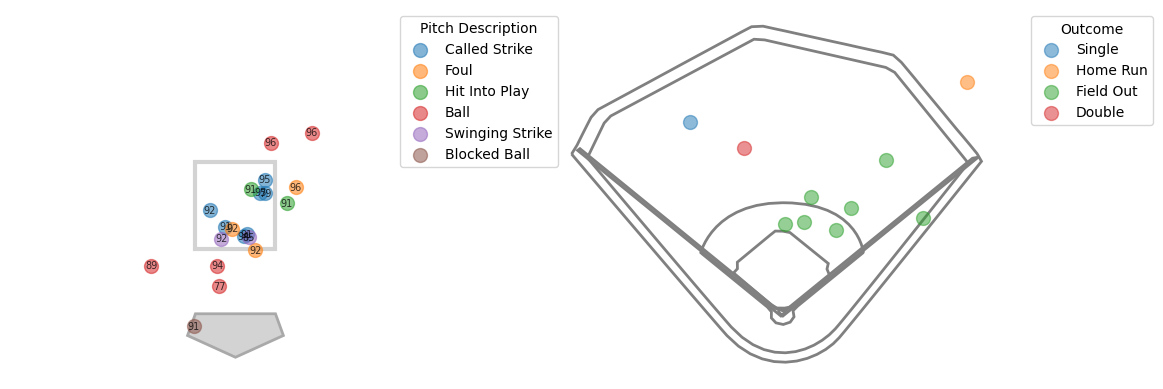

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12.8, 4.8))
plot_strike_zone(all_pitches.iloc[:20], colorby = 'description', annotation = "release_speed", axis = ax1)
ax2.axis("off")

spraychart1(df.iloc[:50], "orioles", axis = ax2)


### Make a wrapper for the headshot getter

In [34]:
def get_player_headshot(mlbam_id, size = 200, file_path = "data/headshots/", file_name = None):
    
    base_img_url = "https://img.mlbstatic.com/mlb-photos/image/upload/w_{size},q_200/v1/people/{mlbam_id}/headshot/silo/current".format(size = size, mlbam_id = mlbam_id)
    
    print(base_img_url)
    
    img_resp = requests.get(base_img_url)
    
    if img_resp.status_code != 200:
        print(img_resp.status_code)
        
        return -1
    else:
        os.makedirs(file_path, exist_ok=True)
        
        if file_name is None:
            file_name = str(mlbam_id) + ".png"
            
            
        with open(file_path + file_name, 'wb') as f:
            f.write(img_resp.content)
    

In [35]:
get_player_headshot(664284)

https://img.mlbstatic.com/mlb-photos/image/upload/w_200,q_200/v1/people/664284/headshot/silo/current


https://img.mlbstatic.com/mlb-photos/image/upload/w_200,q_200/v1/people/664285/headshot/silo/current


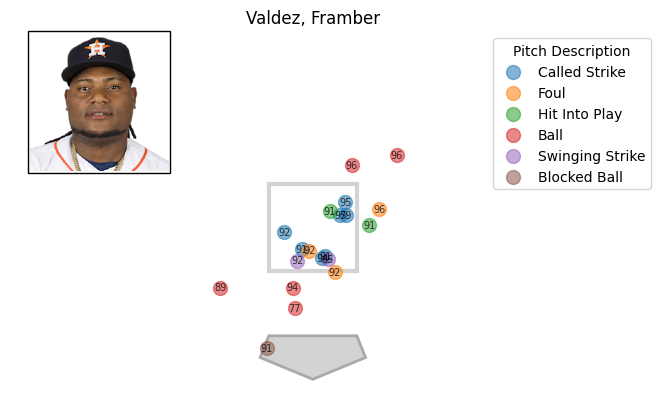

In [38]:
fig, ax = plt.subplots()

# IDK what this does tbh
xy = (1.05, 1)

player_id = all_pitches.pitcher[0]

get_player_headshot(player_id)

im = plt.imread("data/headshots/{}.png".format(player_id))

plot_strike_zone(all_pitches.iloc[:20], colorby = 'description', annotation = "release_speed", axis = ax, title=all_pitches.player_name[0])

imagebox = OffsetImage(im, zoom=0.5)
imagebox.image.axes = ax

ab = AnnotationBbox(imagebox, xy,
                    xybox=(.15, 0.75),
                    xycoords='subfigure fraction',
                    boxcoords="subfigure fraction",
                    pad=0.1)

ax.add_artist(ab)

plt.show()